In [ ]:
import torch
from torch import nn
from einops import einsum
from transformers import AutoTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

INF = torch.finfo(torch.float32).max
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# Classifier Model definition

In [2]:
class ClassAttention(nn.Module):
    def __init__(self, d, n_classes):
        super().__init__()

        self.q = nn.Linear(d, d)
        self.k = nn.Linear(d, d)
        self.v = nn.Linear(d, d)

        self.class_embeddings = nn.Parameter(torch.randn(n_classes, d))

    def forward(self, x, attention_mask=None, return_weights=False):
        queries = self.q(self.class_embeddings)  # (n_classes, d)
        keys = self.k(x)  # (B, L, d)
        values = self.v(x)  # (B, L, d)
        d = x.shape[-1]

        # Compute the attention weights
        s_ij = einsum(queries, keys, "l1 d, b l2 d -> b l1 l2") / d**0.5
        padding_mask = (1.0 - attention_mask) * (-INF)
        s_ij = s_ij + padding_mask[:, None, :]
        # Normalize the weights
        a_ij = torch.softmax(s_ij, dim=-1)  # (n_classes, L)
        # Compute the weighted sum of the values
        output = einsum(a_ij, values, "b l1 l2, b l2 d -> b l1 d")  # (n_classes, d)
        if return_weights:
            return output, a_ij
        return output

class ClassAttentionModel(nn.Module):
    def __init__(self, vocab_size, d, n_classes):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, d)
        self.class_attention = ClassAttention(d, n_classes)

    def forward(self, x, attention_mask):
        x = self.embeddings(x)
        x = self.class_attention(x, attention_mask)  # (B, n_classes, d)
        return x.mean(dim=-1)  # (B, n_classes)

# Training Functions

In [3]:
def validation_step(valid_dataloader, model, criterion):
    n_valid = len(valid_dataloader.dataset)
    model.eval()
    total_loss = 0.0
    correct = 0
    n_iter = 0
    with torch.no_grad():
        for batch in valid_dataloader:
            input_ids = batch["input_ids"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)
            pad_mask = batch["pad_mask"].to(DEVICE)
            output = model(input_ids, pad_mask)
            loss = criterion(output, labels)
            total_loss += loss.item()
            correct += (output.argmax(axis=-1) == labels).sum().item()
            n_iter += 1
    return total_loss / n_iter, correct / n_valid


def train_one_epoch(train_dataloader, model, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    n_train = len(train_dataloader.dataset)
    n_iter = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        pad_mask = batch["pad_mask"].to(DEVICE)
        class_scores = model(input_ids, pad_mask)  # (B, 4)

        loss = criterion(class_scores, labels)  # scalaire (1,)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (class_scores.argmax(axis=-1) == labels).sum().item()
        n_iter += 1

    return total_loss / n_iter, correct / n_train


def train(model, train_dataloader, valid_dataloader, lr=0.01, n_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Track training loss, training accuracy, validation loss and validation accuracy and plot in the end
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    model.to(DEVICE)
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_accuracy = train_one_epoch(
            train_dataloader, model, optimizer, criterion
        )
        valid_loss, valid_accuracy = validation_step(valid_dataloader, model, criterion)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

    return train_losses, train_accuracies, valid_losses, valid_accuracies

# Load Pre-Trained Embeddings

In [4]:
def load_embedding_weights(model, ckpt_path, device=None, freeze=True):
    """
    Charge les embeddings pré-entraînés du modèle Word2Vec
    dans le modèle de classification.
    """

    checkpoint = torch.load(ckpt_path, map_location=device or "cpu")

    if isinstance(checkpoint, dict) and "lookup_table_words.weight" in checkpoint:
        pretrained_embeddings = checkpoint["lookup_table_words.weight"]

    elif isinstance(checkpoint, torch.Tensor):
        pretrained_embeddings = checkpoint

    elif isinstance(checkpoint, dict) and "state_dict" in checkpoint:
        pretrained_embeddings = checkpoint["state_dict"]["lookup_table_words.weight"]

    else:
        raise KeyError(
            f"Impossible de trouver 'lookup_table_words.weight' dans le checkpoint {ckpt_path}.\n"
            f"Clés disponibles : {list(checkpoint.keys()) if isinstance(checkpoint, dict) else 'non applicable'}"
        )

    # Vérifie que les dimensions correspondent
    if model.embeddings.weight.shape != pretrained_embeddings.shape:
        raise ValueError(
            f"Incompatible shapes: classification embeddings "
            f"{tuple(model.embeddings.weight.shape)} vs "
            f"pretrained {tuple(pretrained_embeddings.shape)}"
        )

    # Copie les poids
    with torch.no_grad():
        model.embeddings.weight.copy_(pretrained_embeddings)

    # Option : freeze
    if freeze:
        model.embeddings.weight.requires_grad = False
        print(f"Embeddings loaded and frozen from {ckpt_path}")
    else:
        print(f"Embeddings loaded (trainable) from {ckpt_path}")

# On attache la fonction à notre modèle (pour pouvoir l'utiliser en tant que méthode)
ClassAttentionModel.load_embedding_weights = load_embedding_weights

# AG News Data Set Loading

In [ ]:
TOKENIZER = AutoTokenizer.from_pretrained("bert-base-uncased")
CLASS_NAMES = ["World", "Sports", "Business", "Sci/Tech"]
NUM_CLASS_EXAMPLES = 5000
BATCH_SIZE = 1024

In [6]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # Tokenize the texts
        labels = [example["label"] for example in batch]
        tokenized_texts = [example["input_ids"] for example in batch]
        # Pad the tokenized texts
        max_len = max(len(text) for text in tokenized_texts)
        padded_texts = [
            text + [self.tokenizer.pad_token_id] * (max_len - len(text))
            for text in tokenized_texts
        ]
        pad_mask = [
            [1] * len(text) + [0] * (max_len - len(text)) for text in tokenized_texts
        ]
        return {
            "input_ids": torch.tensor(padded_texts),
            "pad_mask": torch.tensor(pad_mask),
            "labels": torch.tensor(labels),
        }

def preprocess_text(x):
    ids = TOKENIZER(x["description"], truncation=True, max_length=256, padding=False)[
        "input_ids"
    ]
    return {"input_ids": ids, "label": x["label"] - 1}

In [ ]:
dataset = load_dataset("sh0416/ag_news")
dataset = dataset["train"].select(range(NUM_CLASS_EXAMPLES))
dataset = dataset.shuffle(seed=42)
dataset = dataset.train_test_split(test_size=0.3, seed=1234)

dataset = dataset.map(preprocess_text)

n_train = len(dataset["train"])
n_valid = len(dataset["test"])
data_collator = DataCollator(TOKENIZER)
train_dataloader = DataLoader(
    dataset["train"], batch_size=BATCH_SIZE, collate_fn=data_collator, shuffle=True
)
valid_dataloader = DataLoader(
    dataset["test"], batch_size=BATCH_SIZE, collate_fn=data_collator, shuffle=False
)

# Classification Trainings

## Fixed Parameters

In [8]:
EMBED_DIM = 10
N_CLASSES = 4
CLASSIFICATION_EPOCHS = 150
LR = 1e-3
freeze = False

## Evaluating the impact of dataset size on the classification performance

⚠️ Please, ensure that you first run the notebook `word2vec.ipynb`. Or that you have a folder `checkpoints` containing the Word2Vec embeddings.

In [ ]:
r=10
k=5

results_history_examples = {}
for NUM_CLASS_EXAMPLES in [5000, 20000] :

  run_name = f"NUM_EXAMPLES={NUM_CLASS_EXAMPLES}"

  dataset = load_dataset("sh0416/ag_news")
  dataset = dataset["train"].select(range(NUM_CLASS_EXAMPLES))
  dataset = dataset.shuffle(seed=42)
  dataset = dataset.train_test_split(test_size=0.3, seed=1234)

  dataset = dataset.map(preprocess_text)

  n_train = len(dataset["train"])
  n_valid = len(dataset["test"])
  data_collator = DataCollator(TOKENIZER)
  train_dataloader = DataLoader(
      dataset["train"], batch_size=BATCH_SIZE, collate_fn=data_collator, shuffle=True
  )
  valid_dataloader = DataLoader(
      dataset["test"], batch_size=BATCH_SIZE, collate_fn=data_collator, shuffle=False
  )


  w2v_ckpt_path = f"checkpoints/model_embed_words-{EMBED_DIM}_radius-{r}_ratio-{k}_batch-1024_epoch-20.ckpt"

  model_w2v = ClassAttentionModel(vocab_size=TOKENIZER.vocab_size, d=EMBED_DIM, n_classes=N_CLASSES)
  model_w2v.load_embedding_weights(w2v_ckpt_path, DEVICE, freeze=freeze)

  train_losses, train_accs, valid_losses, valid_accs = train(
              model=model_w2v,
              train_dataloader=train_dataloader,
              valid_dataloader=valid_dataloader,
              lr=LR,
              n_epochs=CLASSIFICATION_EPOCHS,
          )

  # -- Model Loading --
  model_vanilla = ClassAttentionModel(vocab_size=TOKENIZER.vocab_size, d=EMBED_DIM, n_classes=N_CLASSES)

  # -- Training --
  train_losses_vanilla, train_accuracies_vanilla, valid_losses_vanilla, valid_accuracies_vanilla = \
  train(model=model_vanilla, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader, lr=LR, n_epochs=CLASSIFICATION_EPOCHS)

  results_history_examples[run_name] = {
            'train_losses': train_losses,
            'train_accuracies': train_accs,
            'valid_losses': valid_losses,
            'valid_accuracies': valid_accs,
            'train_losses_vanilla': train_losses_vanilla,
            'train_accuracies_vanilla': train_accuracies_vanilla,
            'valid_losses_vanilla': valid_losses_vanilla,
            'valid_accuracies_vanilla': valid_accuracies_vanilla
        }

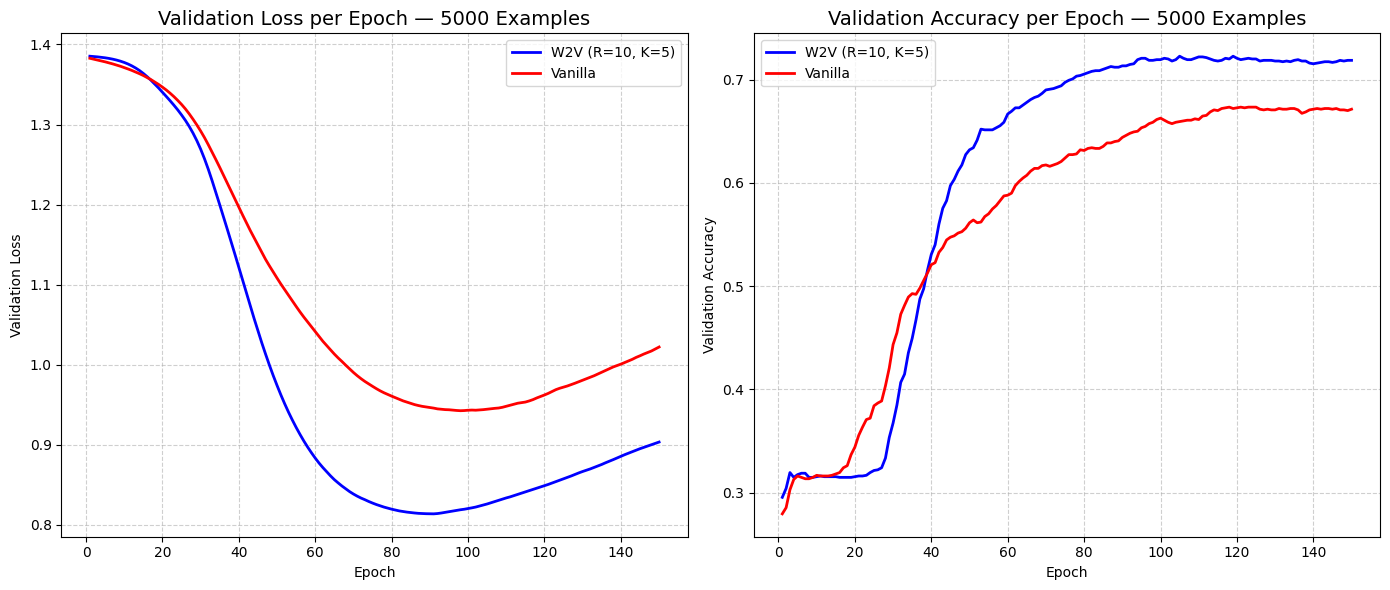

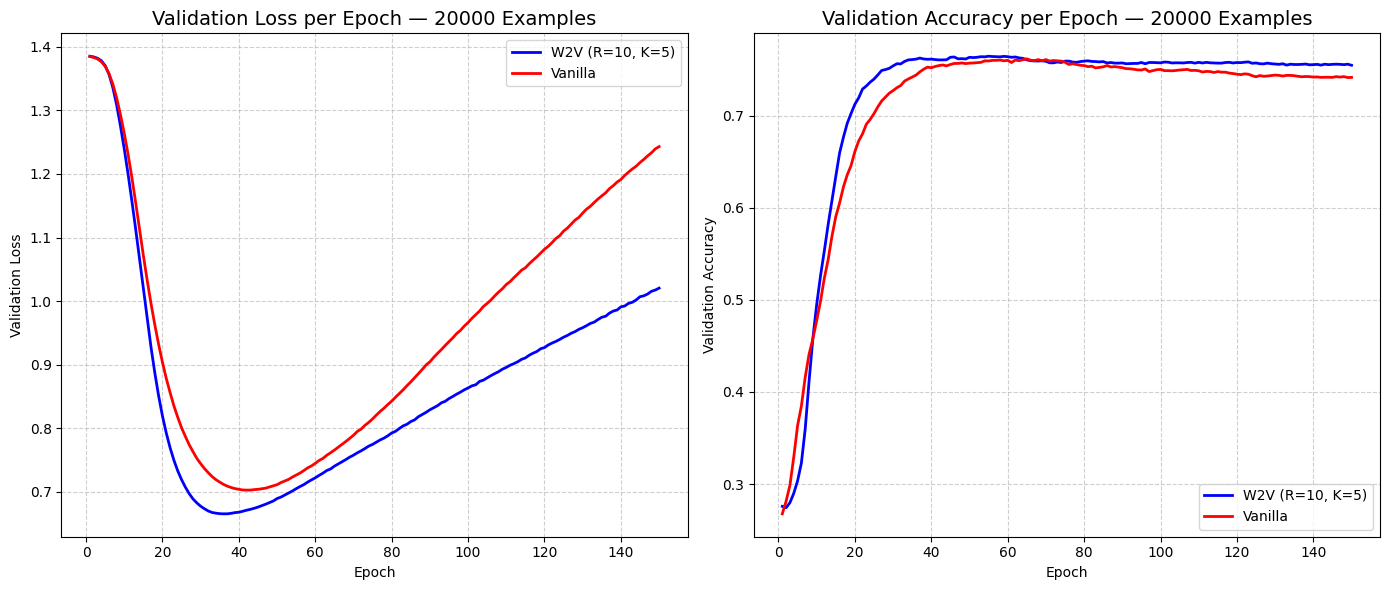

In [14]:
for key, value in results_history_examples.items():
    num_examples = key.split('=')[1]

    valid_losses = value['valid_losses']
    valid_accuracies = value['valid_accuracies']
    valid_losses_vanilla = value['valid_losses_vanilla']
    valid_accuracies_vanilla = value['valid_accuracies_vanilla']

    epochs = range(1, len(valid_losses) + 1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, valid_losses, label='W2V (R=10, K=5)', color='blue', linewidth=2)
    plt.plot(epochs, valid_losses_vanilla, label='Vanilla', color='red', linewidth=2)
    plt.title(f'Validation Loss per Epoch — {num_examples} Examples', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, valid_accuracies, label='W2V (R=10, K=5)', color='blue', linewidth=2)
    plt.plot(epochs, valid_accuracies_vanilla, label='Vanilla', color='red', linewidth=2)
    plt.title(f'Validation Accuracy per Epoch — {num_examples} Examples', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    plt.tight_layout()
    plt.show()


## Ablation study

⚠️ Please, ensure that you first run the notebook `word2vec.ipynb`. Or that you have a folder `checkpoints` containing all the necessary Word2Vec embeddings. /!\

### Run classification training for different initial embeddings

In [ ]:
# --- Define parameters ---
radius = [5, 10, 15]
ratios = [1, 2, 5]

# --- This dictionary will store all our grid search results ---
results_history = {}

# --- Main loop ---
for r in radius:
    for k in ratios:
        run_name = f"R={r}_K={k}"
        print(f"\n" + "="*50)
        print(f"STARTING RUN: {run_name} (Freeze={freeze})")
        print("="*50)

        w2v_ckpt_path = f"checkpoints/model_embed_words-{EMBED_DIM}_radius-{r}_ratio-{k}_batch-1024_epoch-20.ckpt"

        model_w2v = ClassAttentionModel(vocab_size=TOKENIZER.vocab_size, d=EMBED_DIM, n_classes=N_CLASSES)
        model_w2v.load_embedding_weights(w2v_ckpt_path, DEVICE, freeze=freeze)

        train_losses, train_accs, valid_losses, valid_accs = train(
            model=model_w2v,
            train_dataloader=train_dataloader,
            valid_dataloader=valid_dataloader,
            lr=LR,
            n_epochs=CLASSIFICATION_EPOCHS,
        )

        results_history[run_name] = {
            'train_losses': train_losses,
            'train_accuracies': train_accs,
            'valid_losses': valid_losses,
            'valid_accuracies': valid_accs
        }


### Impact of the context window size

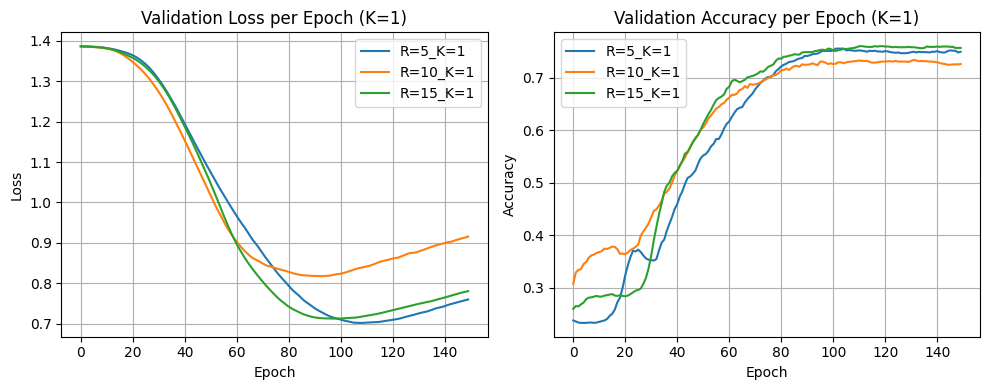

In [ ]:
target_configs = [f"R={r}_K=1" for r in [5, 10, 15]]

plt.figure(figsize=(10, 4))

# (a) Validation Loss
plt.subplot(1, 2, 1)
for config, metrics in results_history.items():
    if config in target_configs:
        plt.plot(metrics["valid_losses"], label=config)
plt.title("Validation Loss per Epoch (K=1)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# (b) Validation Accuracy
plt.subplot(1, 2, 2)
for config, metrics in results_history.items():
    if config in target_configs:
        plt.plot(metrics["valid_accuracies"], label=config)
plt.title("Validation Accuracy per Epoch (K=1)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Impact of the negative sampling ratio

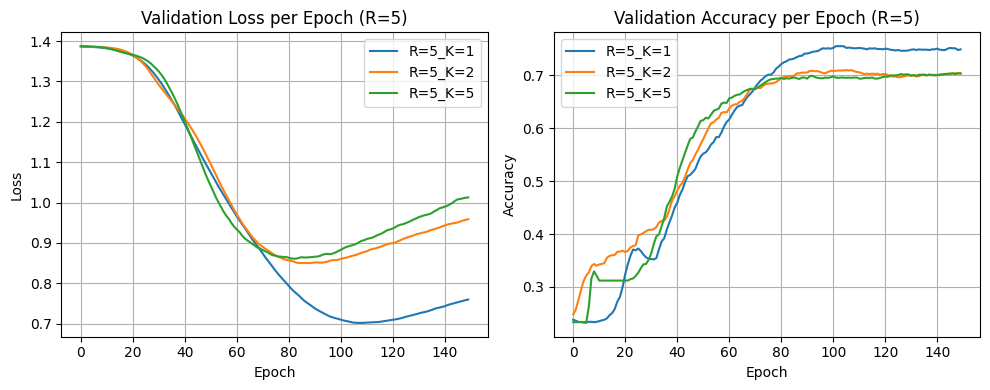

In [ ]:
target_configs = [f"R=5_K={k}" for k in [1, 2, 5]]

plt.figure(figsize=(10, 4))

# (a) Validation Loss
plt.subplot(1, 2, 1)
for config, metrics in results_history.items():
    if config in target_configs:
        plt.plot(metrics["valid_losses"], label=config)
plt.title("Validation Loss per Epoch (R=5)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# (b) Validation Accuracy
plt.subplot(1, 2, 2)
for config, metrics in results_history.items():
    if config in target_configs:
        plt.plot(metrics["valid_accuracies"], label=config)
plt.title("Validation Accuracy per Epoch (R=5)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()